In [4]:
#Load USPS Dataset
import h5py
path="usps.h5"
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        X_test = test.get('data')[:]
        y_test = test.get('target')[:]

#Load Libraries
from sklearn.model_selection import train_test_split
import numpy as np
import math 
import matplotlib.pyplot as plt 
import time
from sklearn.svm import SVC
%matplotlib inline

In [5]:
#Concatenate training and test set
X=np.row_stack((X_train,X_test))
y=np.append(y_train,y_test)
#Split into and initial training set size and the rest of the data
X_train_p, X_other, y_train_p, y_other = train_test_split(X, y, random_state=0,test_size=0.85)


In [6]:
print("Training Proper Size:", len(X_train_p))
print("Other Data Samples:",len(X_other))

Training Proper Size: 1394
Other Data Samples: 7904


# Online Mode 3 SVM ICAD

In [7]:
#Create anomalous data samples
X_other[260][0:256:2]=1
X_other[940][0:256:2]=1
X_other[1350][0:256:2]=1
X_other[4580][0:256:2]=1
X_other[3260][0:256:2]=1
X_other[6010][0:256:2]=1

In [8]:
p_values=np.zeros((len(X_other)))
online_X_train=X_train_p.copy()
online_y_train=y_train_p.copy()
online_X_cal=[]
online_y_cal=[]
score_cal=[]
SVM=SVC()
SVM.fit(online_X_train,online_y_train)
for i in range(len(X_other)):
    d_func=SVM.decision_function([X_other[i]])
    if len(online_X_cal)==0:
        p_values[i]=1
        online_X_cal=X_other[i].reshape(1,len(X_other[0]))
        online_y_cal=y_other[i]
    else:
        score_extend=np.append(score_cal,(-1*d_func[0][y_other[i]]))
        #Calculate p-values of test sample
        p_values[i]=np.mean(score_extend>=score_extend[-1])
        #tau=np.random.uniform()
        #p_values[i]=(np.sum(score_extend>score_extend[-1])+(tau*(np.sum(score_extend==score_extend[-1]))))/len(score_extend)
        online_X_cal=np.row_stack((online_X_cal,X_other[i]))
        online_y_cal=np.append(online_y_cal,y_other[i])
    score_cal=np.append(score_cal,-1*d_func[0][y_other[i]])
    
    if len(online_X_cal) > 1000:
        #If calibration set size is greater than 1000, tranfer 800 samples to training set and leave 200 in calibration set
        online_X_train=np.row_stack((online_X_train,online_X_cal[:len(online_X_cal)-200]))
        online_y_train=np.append(online_y_train,online_y_cal[:len(online_y_cal)-200])
        online_X_cal=online_X_cal[len(online_X_cal)-200:]
        online_y_cal=online_y_cal[len(online_y_cal)-200:]
        #Re-fit SVM to new training set
        SVM.fit(online_X_train,online_y_train)
        #Re-calculate calibration set scores
        d_func_cal=SVM.decision_function(online_X_cal)
        row=np.arange(0,len(d_func_cal))
        score_cal=-1*d_func_cal[row,online_y_cal]

In [9]:
#Find anomalies where the label is less than the significance level
sig=0.01
anom_indicator=np.zeros((len(X_other)))
for i in range(len(X_other)):
    if p_values[i] < sig:
        anom_indicator[i]=True
    else:
        anom_indicator[i]=False

In [10]:
#Get samples that were detected as anomalies
anomalies=X_other[anom_indicator==1]
labels=y_other[anom_indicator==1]

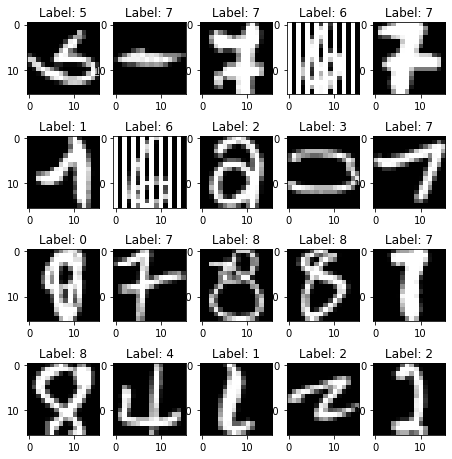

In [13]:
# Plot images of anomalies
total=20
column=5
row=4
fig, axes = plt.subplots(row, column, figsize=(1.5*column,2*row))
for i in range(total):
    #Reshape images back to 16x16
    anom_reshape=anomalies[i].reshape(16,16)
    ax = axes[i//column, i%column]
    ax.imshow(anom_reshape, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.show()